In [1]:
# -*- coding: utf-8 -*-




In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import StPedf
import spaTrack as spt
from anndata import AnnData
from sklearn.metrics import pairwise_distances
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

random_seed = 2025
StPedf.fix_seed(random_seed)

In [ ]:

import torch
# %% 
# 导入库
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import ot
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import TI as spt
from anndata import AnnData

In [ ]:

adata = sc.read('F:/StPedf/data/multiple.ST.slices.axolotl.brain/cell.exp.tsv')
df_annot = pd.read_table('F:/StPedf/data/multiple.ST.slices.axolotl.brain/cell.meta.tsv')

adata.obs["cluster"] = df_annot['cluster'].values
adata.obs["Time"] = df_annot['Time'].values
adata.obsm["spatial"] = df_annot[['x','y']].values 
adata.obsm["X_umap"] = df_annot[['UMAP_1','UMAP_2']].values



Text(0.5, 1.0, 'UMAP')

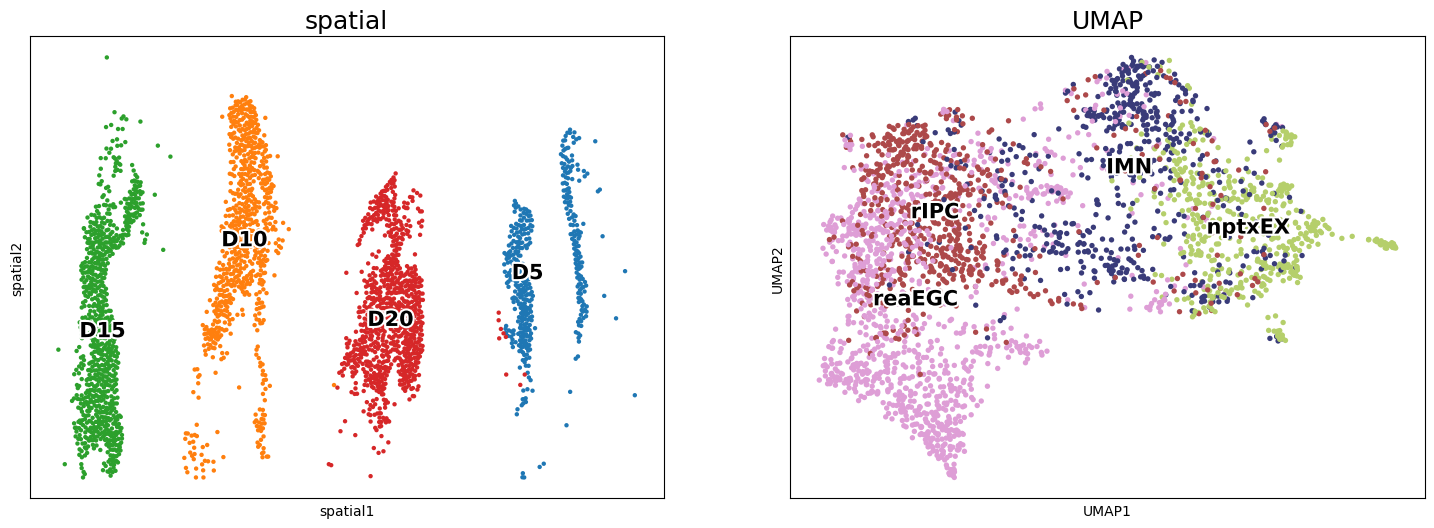

In [5]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(18, 6))
sc.pl.embedding(adata, basis='spatial', color='Time', size=50, legend_fontsize=15,legend_loc='on data', ax=axs[0], legend_fontoutline=3, show=False, s=40)
axs[0].set_title('spatial',fontsize=18)
sc.pl.umap(adata,color='cluster',ax=axs[1],legend_loc='on data',size=50,legend_fontoutline=3, legend_fontsize=15,palette='tab20b',show=False,s=60)
axs[1].set_title('UMAP',fontsize=18)

In [6]:
adata.uns['cluster_colors']=['#5254a3', '#8c6d31','#EEDC82','#d6616b']

In [ ]:
time_and_start = {"D5": "reaEGC", "D10": "reaEGC", "D15": "reaEGC", "D20": "rIPC"}

P_all = V_all = np.array([]).reshape(0, 2)

Text(0.5, 1.0, 'spatial')

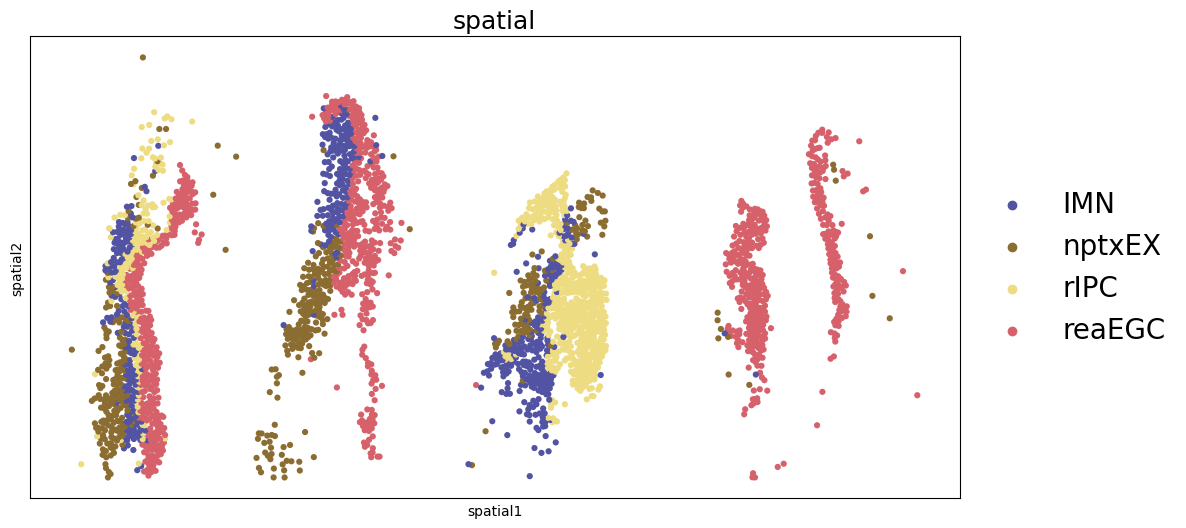

In [8]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(12, 6))
sc.pl.embedding(adata, basis='spatial', color='cluster', size=50, legend_loc='right margin', legend_fontsize=20,ax=axs, legend_fontoutline=3, show=False, s=80)
axs.set_title('spatial',fontsize=18)

In [ ]:
def construct_adaptive_transition_matrix(
    adata: AnnData,
    sedr_key: str = 'SEDR',
    spatial_key: str = 'spatial',
    reg: float = 0.1,
    base_alpha: float = 0.5,  
    alpha_range: tuple = (0.3, 0.7), 
    spot_size: float = 100 
):

    sedr_emb = adata.obsm[sedr_key]
    spatial_coords = adata.obsm[spatial_key]

    sedr_dist = pairwise_distances(sedr_emb)
    spatial_dist = pairwise_distances(spatial_coords)
    
    sedr_dist /= sedr_dist.max()
    spatial_dist /= spatial_dist.max()
    
    from sklearn.neighbors import KernelDensity

    kde = KernelDensity(bandwidth=50, kernel='gaussian')
    kde.fit(spatial_coords)
    density_scores = np.exp(kde.score_samples(spatial_coords))

    density_norm = (density_scores - density_scores.min()) / (
        density_scores.max() - density_scores.min() + 1e-10)

    min_alpha, max_alpha = alpha_range
    adaptive_alphas = min_alpha + (max_alpha - min_alpha) * (1 - density_norm)

    adata.obs['cell_density'] = density_norm
    adata.obs['spatial_weight'] = adaptive_alphas

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    sc.pl.embedding(
        adata, 
        basis=spatial_key, 
        color='cell_density', 
        ax=axes[0], 
        show=False, 
        title='Cell Density',
        cmap='viridis',
        size=spot_size
    )

    sc.pl.embedding(
        adata, 
        basis=spatial_key, 
        color='spatial_weight', 
        ax=axes[1], 
        show=False, 
        title='Adaptive Weights',
        cmap='coolwarm',
        size=spot_size,
        vmin=min_alpha,
        vmax=max_alpha
    )
    
    plt.tight_layout()
    plt.show()

    M = np.zeros_like(spatial_dist)
    for i in range(len(adata)):
        alpha_i = adaptive_alphas[i]
        M[i] = alpha_i * spatial_dist[i] + (1 - alpha_i) * sedr_dist[i]
    

    a = b = np.ones(M.shape[0]) / M.shape[0]
    Gs = ot.sinkhorn(a, b, M, reg=reg)
    
    return Gs





处理时间点: D5


100%|██████████| 200/200 [00:02<00:00, 80.02it/s]


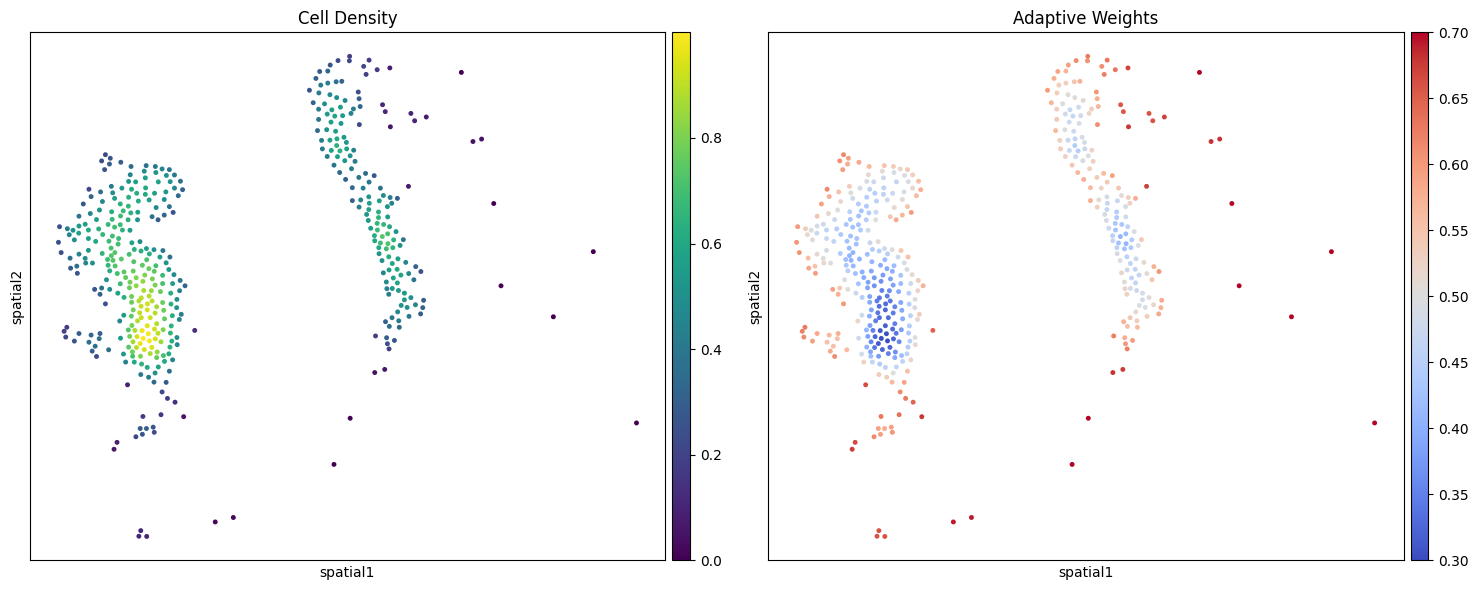

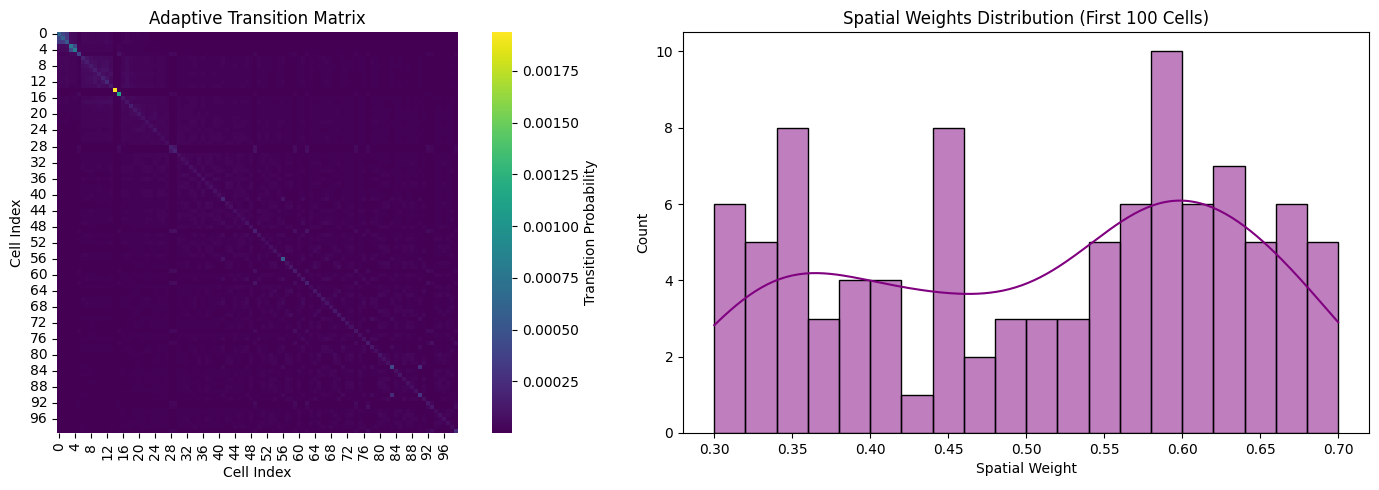


处理时间点: D10


100%|██████████| 200/200 [00:02<00:00, 83.31it/s]


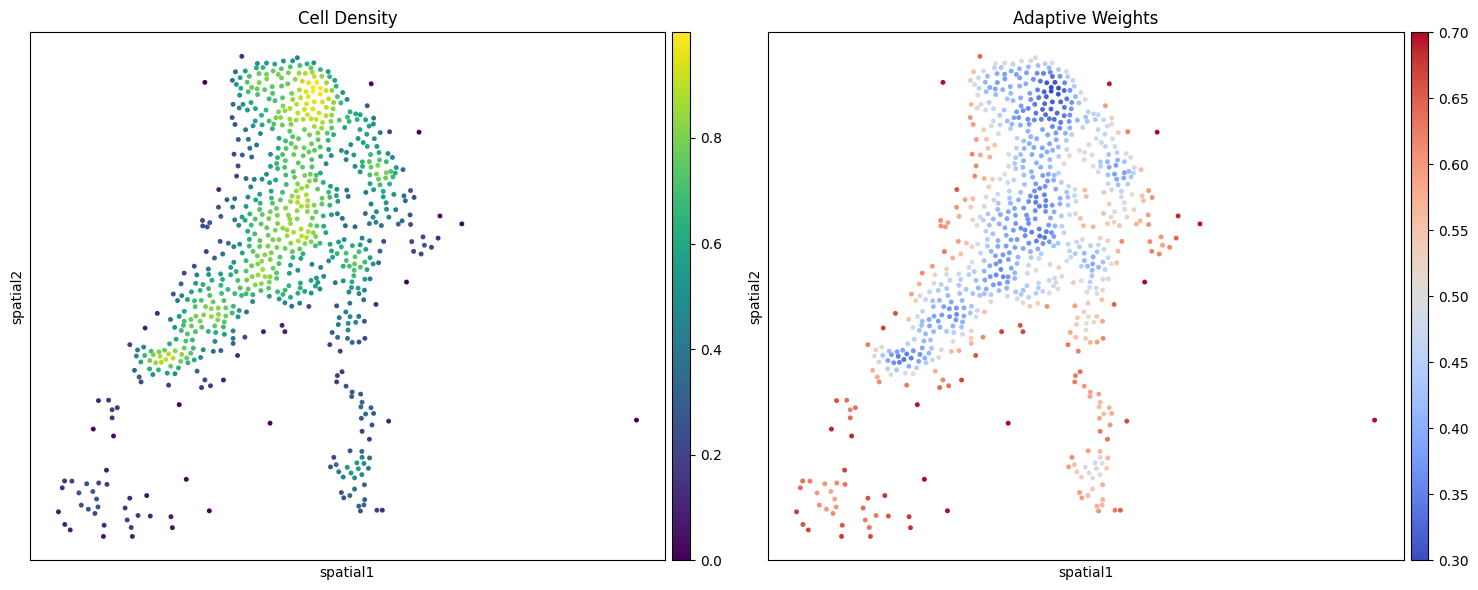

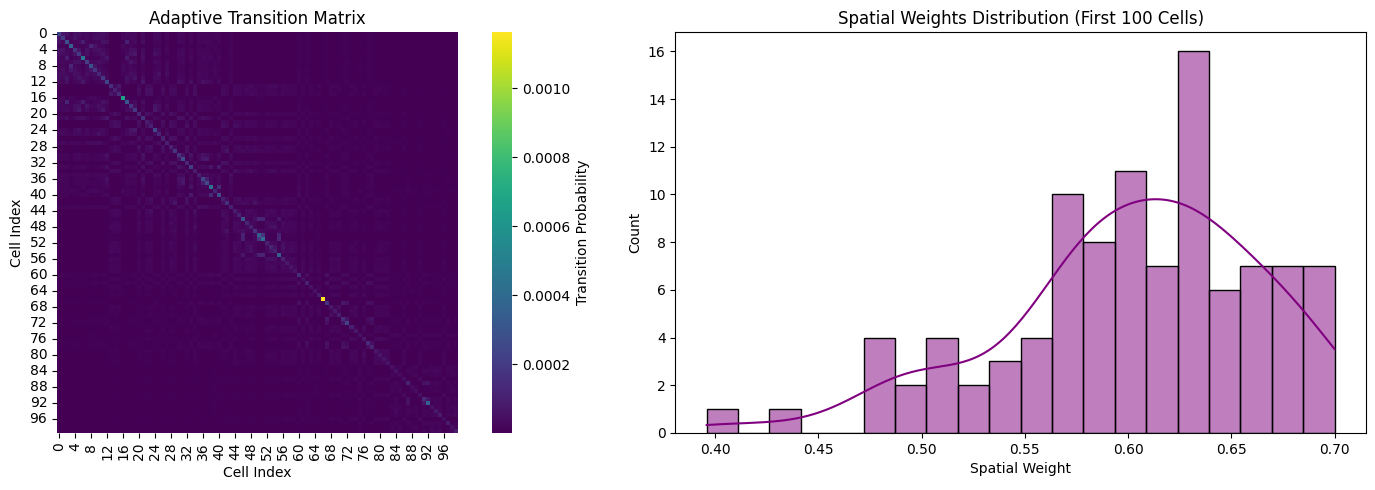


处理时间点: D15


100%|██████████| 200/200 [00:02<00:00, 83.25it/s]


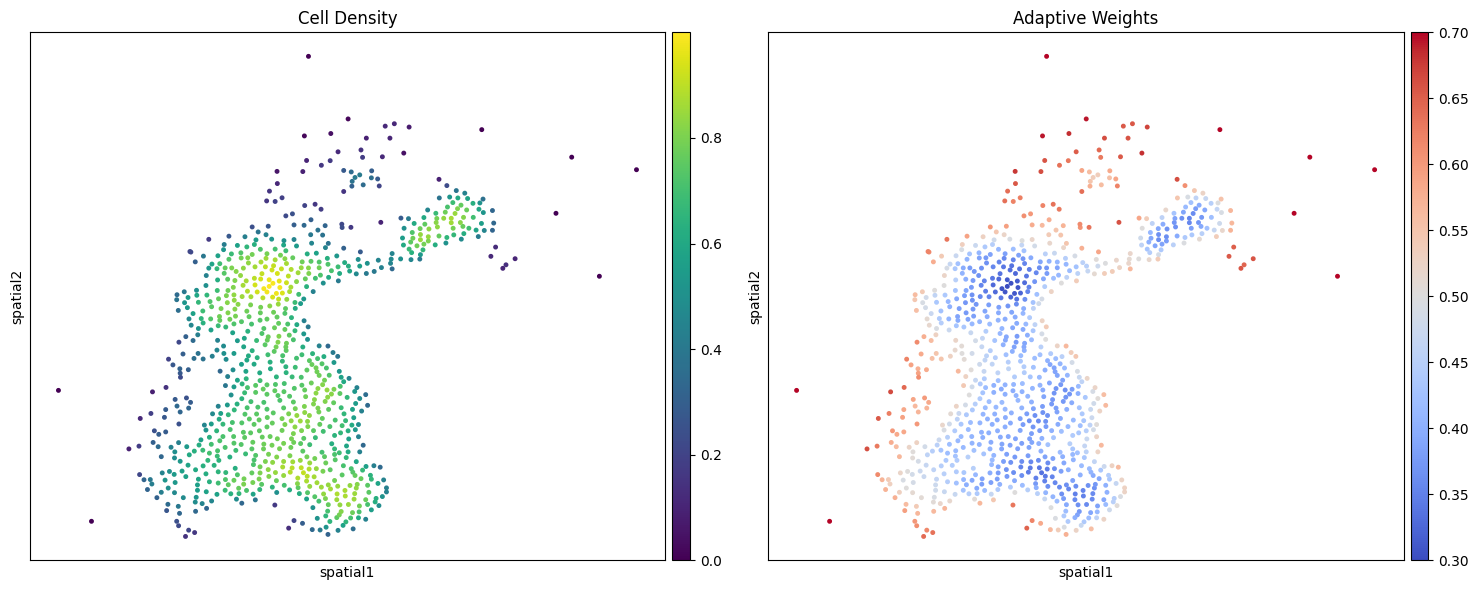

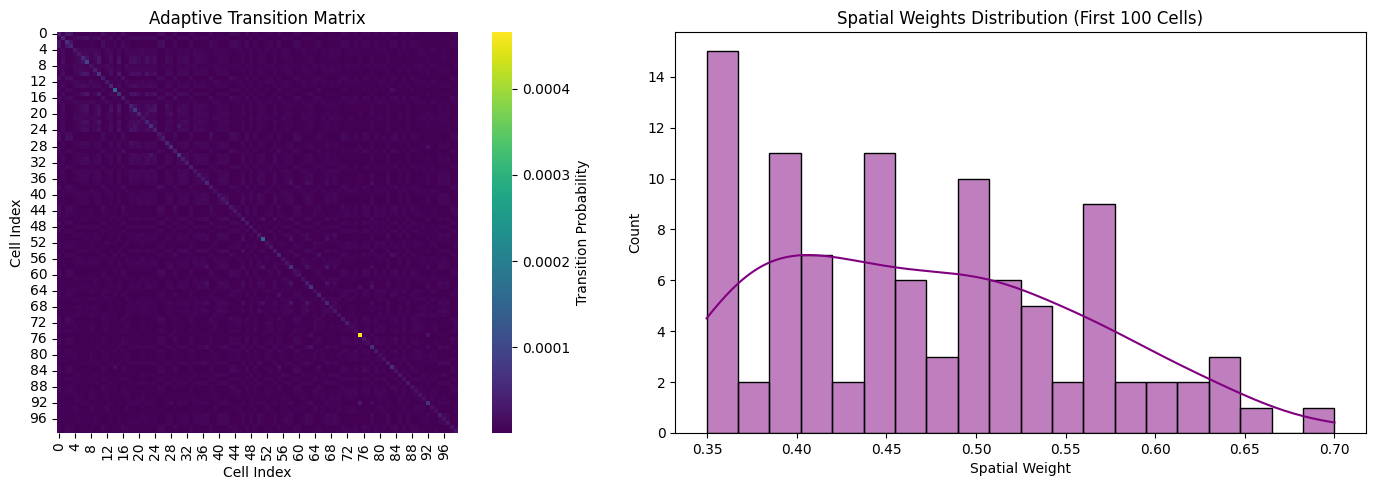


处理时间点: D20


100%|██████████| 200/200 [00:02<00:00, 90.34it/s]


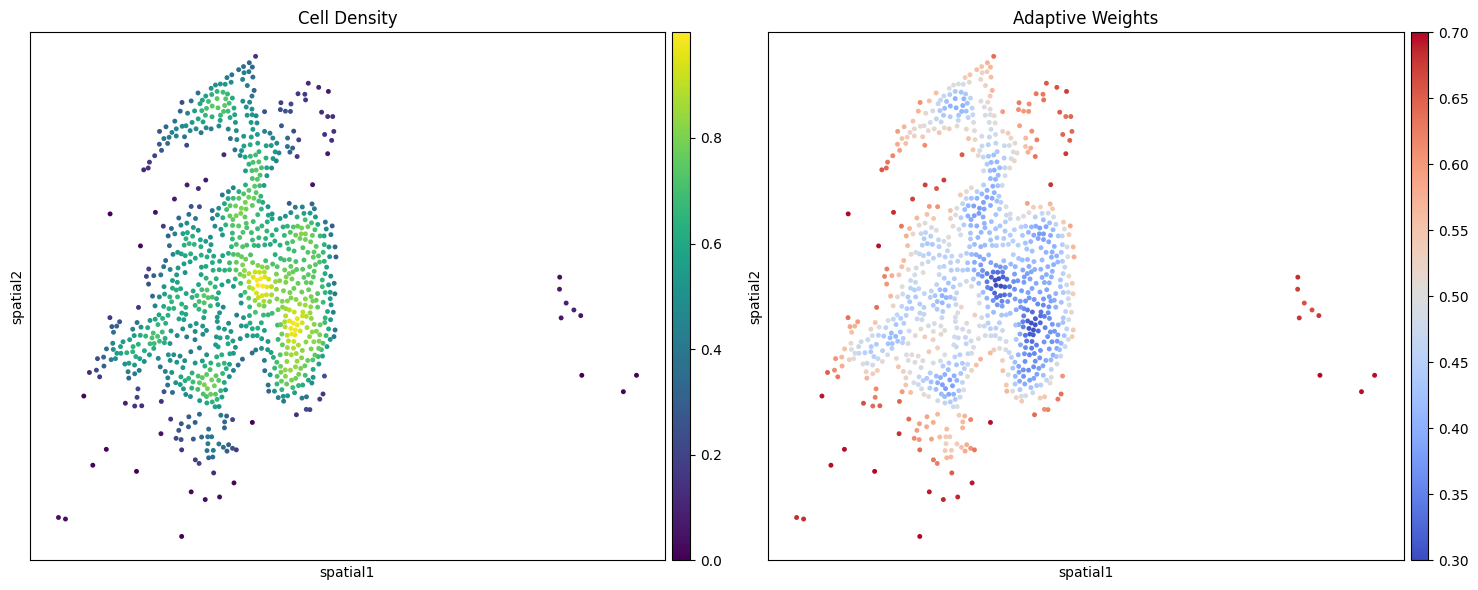

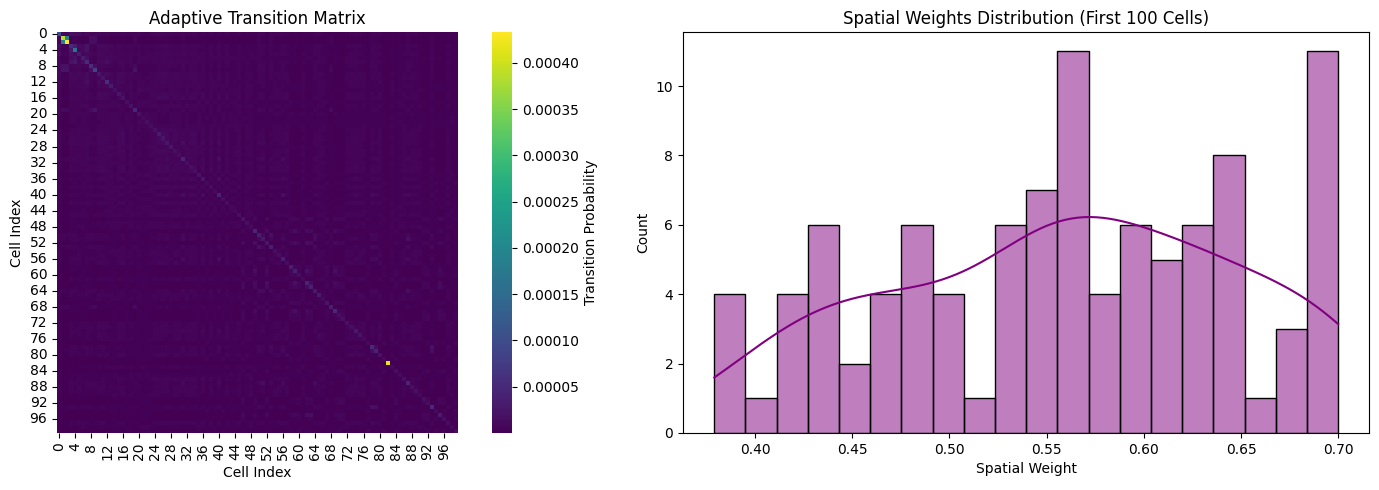

In [ ]:

processed_data = {} 
for time_point in time_and_start.keys():
    print(f"\n处理时间点: {time_point}")
    subadata = adata[adata.obs["Time"] == time_point].copy()        

    sc.pp.filter_genes(subadata, min_cells=10)
    sc.pp.normalize_total(subadata, target_sum=1e4)
    sc.pp.log1p(subadata)
    subadata.layers['count'] = subadata.X.copy()        

    sc.pp.highly_variable_genes(subadata, flavor="seurat_v3", layer='count', n_top_genes=2000)
    subadata = subadata[:, subadata.var['highly_variable']]        

    sc.pp.scale(subadata)
    sc.pp.pca(subadata, n_comps=100)        

    graph_dict = StPedf.graph_construction(
        subadata,         
12,
        mode='AlphaComplex',
        alpha_n_neighbors=15
    )        

    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    sedr_net = StPedf.Sedr(
        subadata.obsm['X_pca'], 
        graph_dict, 
        mode='clustering',
        device=device
    )        

    sedr_net.train_with_dec(N=200)
    sedr_feat, _, _, _, _ = sedr_net.process()
    subadata.obsm['SEDR'] = sedr_feat        

    n_clusters = len(subadata.obs['cluster'].unique())

    trans = construct_adaptive_transition_matrix(
        subadata,
        sedr_key='SEDR',
        spatial_key='spatial',
        reg=0.1,  
        base_alpha=0.5,
        alpha_range=(0.3, 0.7), 
        spot_size=50 
    )

    subadata.obsp["adaptive_trans"] = trans

    plt.figure(figsize=(15, 5))

    plt.subplot(121)
    sns.heatmap(trans[:100, :100], cmap='viridis', square=True, 
                cbar_kws={'label': 'Transition Probability'})
    plt.title("Adaptive Transition Matrix")
    plt.xlabel("Cell Index")
    plt.ylabel("Cell Index")

    plt.subplot(122)
    sns.histplot(subadata.obs['spatial_weight'].iloc[:100], bins=20, 
                kde=True, color='purple')
    plt.title("Spatial Weights Distribution (First 100 Cells)")
    plt.xlabel("Spatial Weight")
    plt.ylabel("Count")

    plt.tight_layout()
    plt.show()
    subadata.obsp["adaptive_trans"] = trans        

    processed_data[time_point] = {        
'subadata': subadata,        
'start_cells_bool': None,         
'start_cells': None       
    }

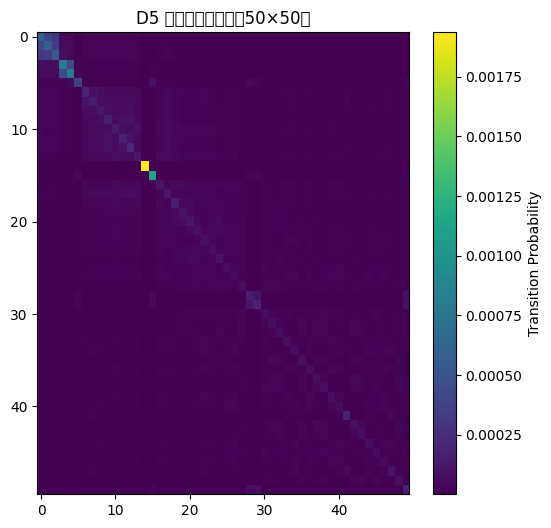

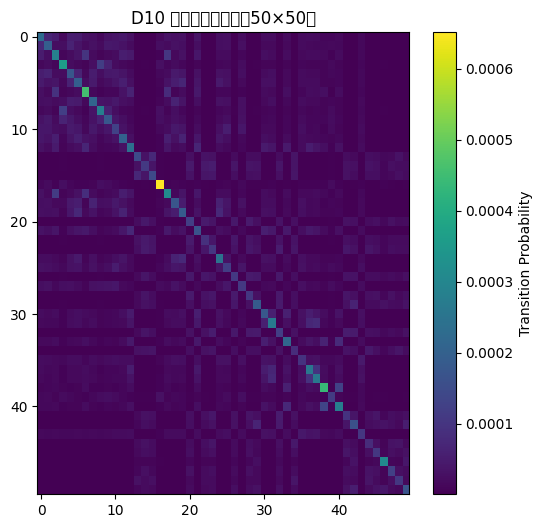

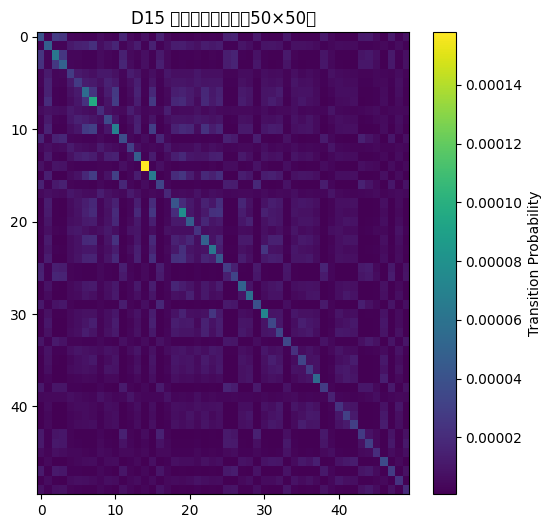

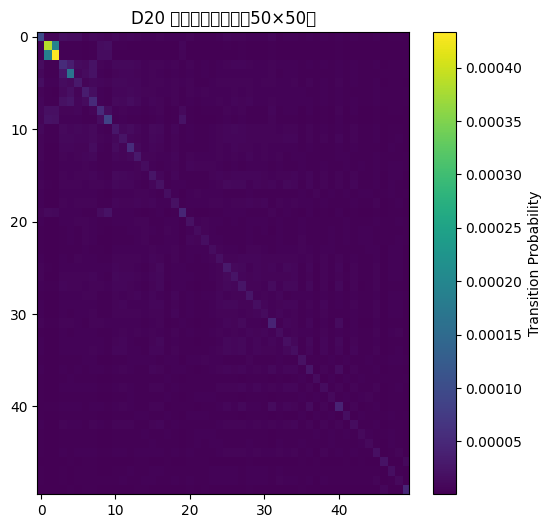

In [ ]:
import matplotlib.pyplot as plt
import scipy.sparse as sp
for time_point in processed_data:
    trans = processed_data[time_point]['subadata'].obsp["adaptive_trans"]
    trans_dense = trans.toarray() if sp.issparse(trans) else trans
    plt.figure(figsize=(6, 6))
    plt.imshow(trans_dense[:50, :50], cmap='viridis', aspect='auto')
    plt.colorbar(label='Transition Probability')
    plt.title(f"{time_point}")
    plt.show()


处理时间点: D5, 起始细胞类型: reaEGC
使用已计算的转移矩阵，形状: (435, 435)
起始细胞数量: 429


<Figure size 800x800 with 0 Axes>

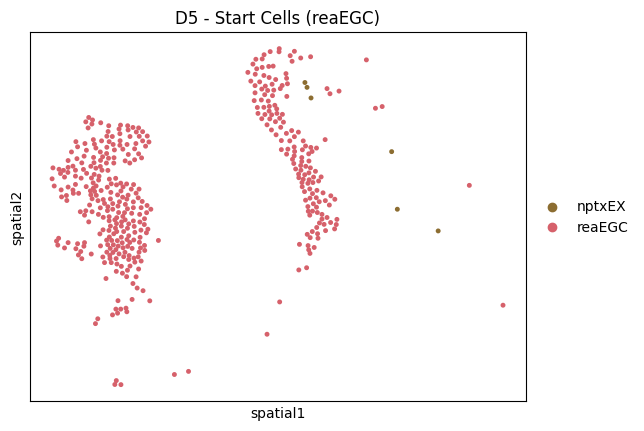

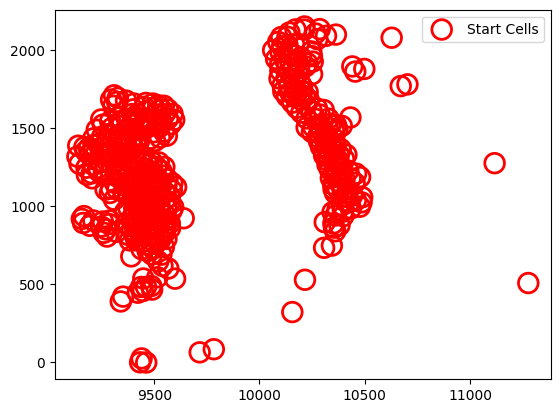

Cell velocities stored in 'velocity_spatial'
Cell velocities stored in 'velocity_umap'

处理时间点: D10, 起始细胞类型: reaEGC
使用已计算的转移矩阵，形状: (738, 738)
起始细胞数量: 375


<Figure size 800x800 with 0 Axes>

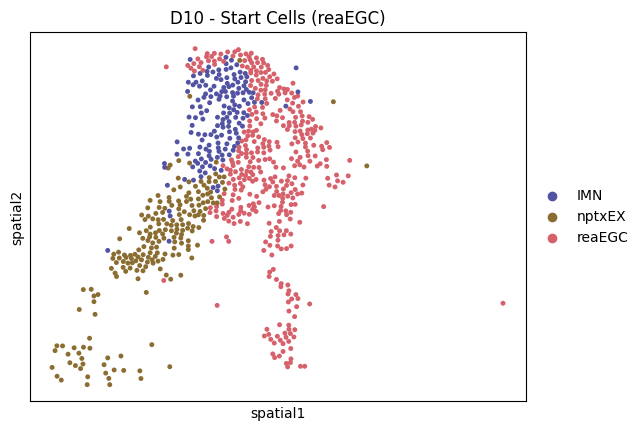

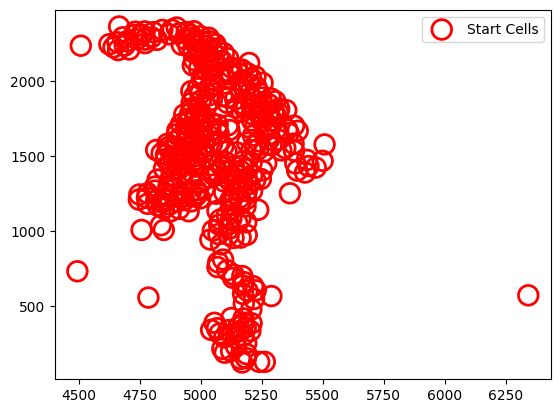

Cell velocities stored in 'velocity_spatial'
Cell velocities stored in 'velocity_umap'

处理时间点: D15, 起始细胞类型: reaEGC
使用已计算的转移矩阵，形状: (820, 820)
起始细胞数量: 322


<Figure size 800x800 with 0 Axes>

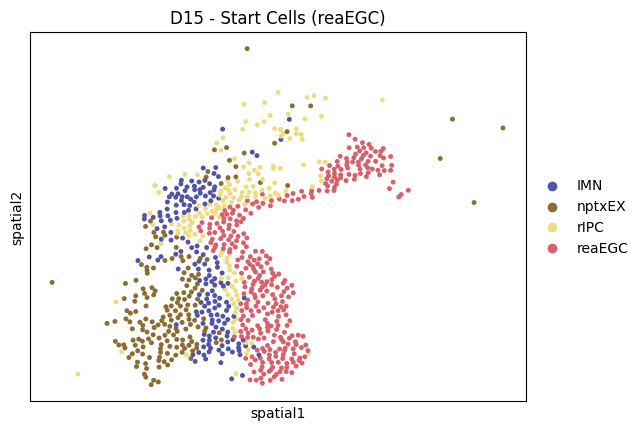

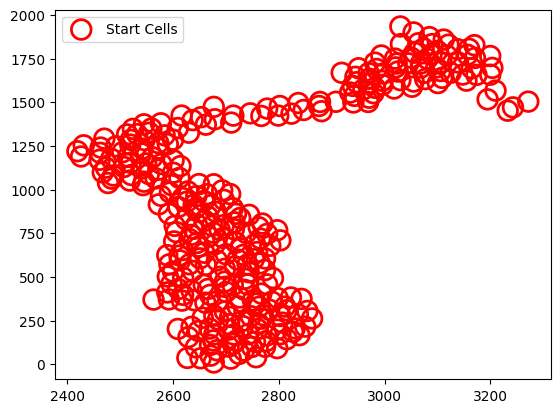

Cell velocities stored in 'velocity_spatial'
Cell velocities stored in 'velocity_umap'

处理时间点: D20, 起始细胞类型: rIPC
使用已计算的转移矩阵，形状: (887, 887)
起始细胞数量: 510


<Figure size 800x800 with 0 Axes>

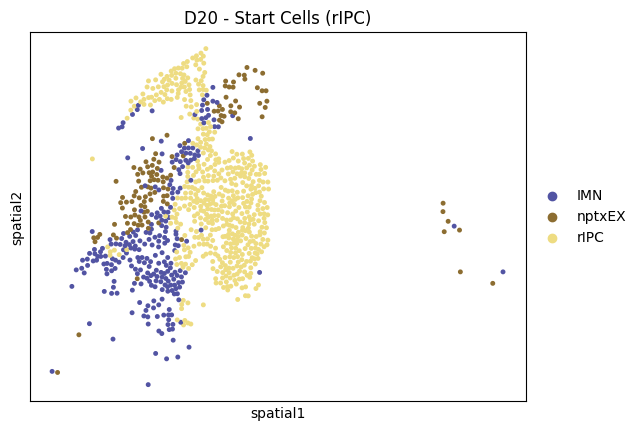

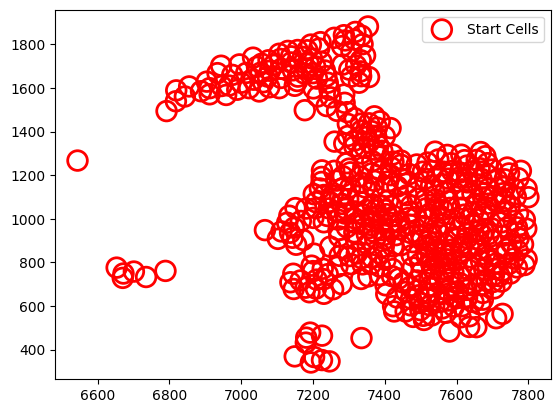

Cell velocities stored in 'velocity_spatial'
Cell velocities stored in 'velocity_umap'


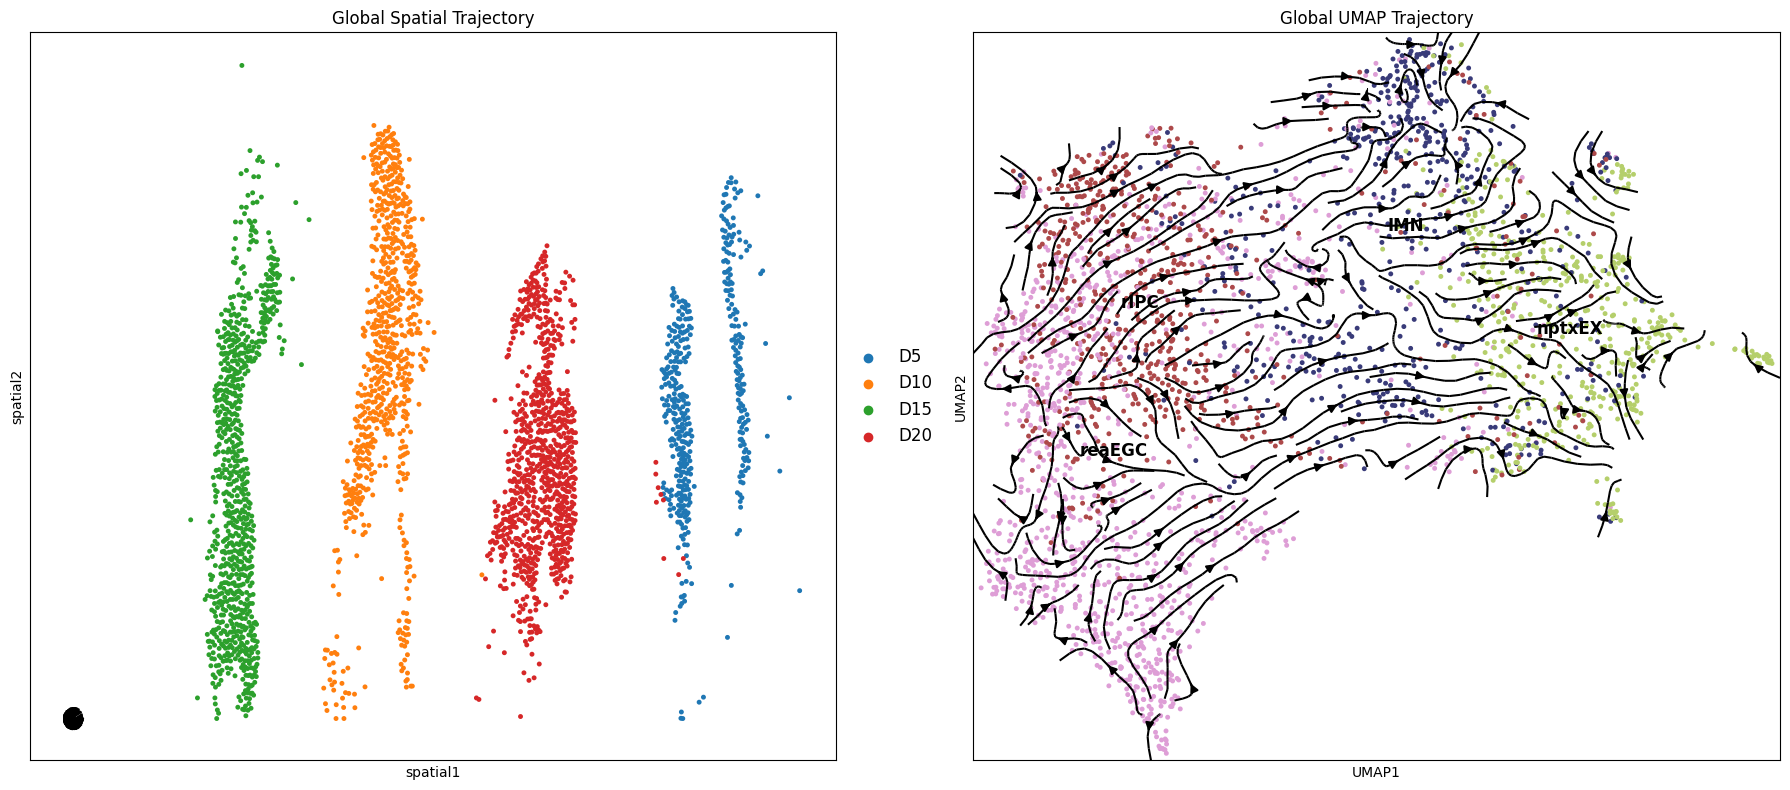

AttributeError: 'numpy.ndarray' object has no attribute 'format'

In [ ]:
time_and_start = {"D5": "reaEGC", "D10": "reaEGC", "D15": "reaEGC", "D20": "rIPC"}
P_all = V_all = np.array([]).reshape(0, 2)

for time_point, start_cluster in time_and_start.items():
    print(f"\n处理时间点: {time_point}, 起始细胞类型: {start_cluster}")
    
    if time_point in processed_data:
        subadata = processed_data[time_point]['subadata'].copy()
    else:
        subadata = adata[adata.obs["Time"] == time_point].copy()
        
    if "adaptive_trans" in subadata.obsp:
        trans = subadata.obsp["adaptive_trans"]
        print(f"使用已计算的转移矩阵，形状: {trans.shape}")
    else:
        trans = construct_adaptive_transition_matrix(
            subadata,
            sedr_key='SEDR',
            spatial_key='spatial',
            reg=0.1,
            base_alpha=0.5,
            alpha_range=(0.3, 0.7),
            spot_size=50
        )
        subadata.obsp["adaptive_trans"] = trans
        print(f"重新计算转移矩阵，形状: {trans.shape}")

    subadata.obsp["trans"] = subadata.obsp["adaptive_trans"]

    start_cells_mask = (subadata.obs['cluster'] == start_cluster)
    start_cells = np.where(start_cells_mask)[0]

    if len(start_cells) == 0:
        print(f"警告: 时间点 {time_point} 未找到细胞类型 {start_cluster}")
  
        available_clusters = subadata.obs['cluster'].unique()
        cluster_distances = [levenshtein_distance(start_cluster, c) for c in available_clusters]
        closest_cluster = available_clusters[np.argmin(cluster_distances)]
        
        print(f"使用最接近的细胞类型: {closest_cluster}")
        start_cells = np.where(subadata.obs['cluster'] == closest_cluster)[0]
    
    print(f"起始细胞数量: {len(start_cells)}")

    plt.figure(figsize=(8, 8))
    sc.pl.embedding(
        subadata, 
        basis='spatial', 
        color='cluster',
        size=50,
        title=f'{time_point} - Start Cells ({start_cluster})'
    )
    plt.scatter(
        subadata.obsm['spatial'][start_cells, 0],
        subadata.obsm['spatial'][start_cells, 1],
        s=200, edgecolor='red', facecolor='none', linewidth=2,
        label='Start Cells'
    )
    plt.legend()
    plt.show()

    subadata.obs["ptime"] = spt.get_ptime(subadata, start_cells)

    if 'X_spatial' not in subadata.obsm:
        subadata.obsm['X_spatial'] = subadata.obsm['spatial'].copy()

    try:
        _, _ = spt.get_velocity(subadata, basis="spatial", n_neigh_pos=80, n_neigh_embed=0)
    except Exception as e:
        print(f"计算空间速度场时出错: {e}")
        subadata.obsm['velocity_spatial'] = np.zeros_like(subadata.obsm['spatial'])
 
    if 'X_umap' in subadata.obsm:
        try:
            _, _ = spt.get_velocity(subadata, basis="umap", n_neigh_pos=80, n_neigh_embed=0)
        except Exception as e:
            print(f"计算UMAP速度场时出错: {e}")
            subadata.obsm['velocity_umap'] = np.zeros_like(subadata.obsm['X_umap'])

    if 'X_umap' in subadata.obsm and 'velocity_umap' in subadata.obsm:
        P_all = np.vstack((P_all, subadata.obsm["X_umap"]))
        V_all = np.vstack((V_all, subadata.obsm["velocity_umap"]))

    processed_data[time_point] = {'subadata': subadata, 'start_cells': start_cells}

if P_all.size > 0 and V_all.size > 0:
    adata.uns['P_grid'], adata.uns['V_grid'] = spt.velocity.get_velocity_grid(
        adata, P=P_all, V=V_all
    )

    fig, axs = plt.subplots(1, 2, figsize=(18, 8))

    sc.pl.embedding(adata, basis='spatial', color='Time', 
                    ax=axs[0], show=False, title='Global Spatial Trajectory',
                    size=50, legend_fontsize=12)
    axs[0].streamplot(adata.uns['P_grid'][0], adata.uns['P_grid'][1], 
                     adata.uns['V_grid'][0], adata.uns['V_grid'][1],
                     density=2, color='black', linewidth=1.5, arrowsize=1.2)

    sc.pl.umap(adata, color='cluster', ax=axs[1], show=False,
              title='Global UMAP Trajectory', palette='tab20b',
              legend_loc='on data', size=50, legend_fontsize=12)
    axs[1].streamplot(adata.uns['P_grid'][0], adata.uns['P_grid'][1], 
                     adata.uns['V_grid'][0], adata.uns['V_grid'][1],
                     density=2, color='black', linewidth=1.5, arrowsize=1.2)

    plt.tight_layout()
    plt.savefig("global_trajectory.png", dpi=300)
    plt.show()
else:
    print("警告: 未找到足够的UMAP数据用于全局可视化")

if "D15" in processed_data:
    d15_adata = processed_data["D15"]['subadata'].copy()
    start_cells = processed_data["D15"]['start_cells']

    if 'spatial' in d15_adata.obsm:
        if 'X_spatial' not in d15_adata.obsm:
            d15_adata.obsm['X_spatial'] = d15_adata.obsm['spatial'].copy()

        if 'velocity_spatial' not in d15_adata.obsm:
            try:
                _, _ = spt.get_velocity(d15_adata, basis="spatial", n_neigh_pos=80, n_neigh_embed=0)
            except Exception as e:
                print(f"计算空间速度场时出错: {e}")
                d15_adata.obsm['velocity_spatial'] = np.zeros_like(d15_adata.obsm['spatial'])

        end_cluster = "rIPC" 
        end_cells = np.where(d15_adata.obs['cluster'] == end_cluster)[0]

        if len(end_cells) == 0:
            print(f"警告: 未找到终点细胞类型 {end_cluster}")
            end_cell_idx = np.argmax(d15_adata.obs['ptime'].values)
            end_cells = [end_cell_idx]

        end_cell_idx = end_cells[np.argmax(d15_adata.obs['ptime'].values[end_cells])]
        end_cell = d15_adata.obs_names[end_cell_idx]

        try:
            VecFld = spt.VectorField(d15_adata, basis='spatial')
        except Exception as e:
            print(f"创建向量场时出错: {e}")
            from TI.single_time.vectorfield import vectorfield
            VecFld = vectorfield(d15_adata, basis='spatial')
        
        if "adaptive_trans" in d15_adata.obsp:
            adj_matrix = d15_adata.obsp["adaptive_trans"]
        else:
            from sklearn.neighbors import kneighbors_graph
            spatial_coords = d15_adata.obsm['spatial']
            adj_matrix = kneighbors_graph(spatial_coords, n_neighbors=15, mode='connectivity')
            d15_adata.obsp["adaptive_trans"] = adj_matrix
        
        lap = spt.least_action(
            d15_adata,
            init_cells=start_cells[:1], 
            target_cells=[end_cell],
            vecfld=VecFld,
            basis="spatial",
            adj_key="adaptive_trans",
            EM_steps=5,
            n_points=20
        )

        fig, ax = plt.subplots(figsize=(8, 8))
        sc.pl.embedding(d15_adata, basis='spatial', color='cluster', 
                       ax=ax, show=False, palette='tab20b', size=100)

        if 'path' in lap:
            for path in lap['path']:
                ax.plot(path[:, 0], path[:, 1], 'r-', linewidth=3)

        ax.scatter(
            d15_adata.obsm['spatial'][start_cells, 0],
            d15_adata.obsm['spatial'][start_cells, 1],
            s=200, edgecolor='green', facecolor='none', linewidth=2,
            label='Start Cells'
        )
        ax.scatter(
            d15_adata.obsm['spatial'][end_cell_idx, 0],
            d15_adata.obsm['spatial'][end_cell_idx, 1],
            s=200, c='purple', marker='*', edgecolor='black',
            label='End Cell'
        )
        
        plt.legend()
        plt.title(f'D15 Least Action Path: {start_cluster} to {end_cluster}', fontsize=16)
        plt.tight_layout()
        plt.savefig("D15_least_action_path.png", dpi=300)
        plt.show()
    else:
        print(f"警告: D15 子数据集缺少空间坐标")
else:
    print("警告: 未找到D15子数据集")

print("多时间点轨迹分析完成!")

def levenshtein_distance(s1, s2):
    """计算两个字符串之间的Levenshtein距离"""
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    
    if len(s2) == 0:
        return len(s1)
    
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

In [16]:
P_grid, V_grid = spt.velocity.get_velocity_grid(
    adata, P=P_all, V=V_all
)

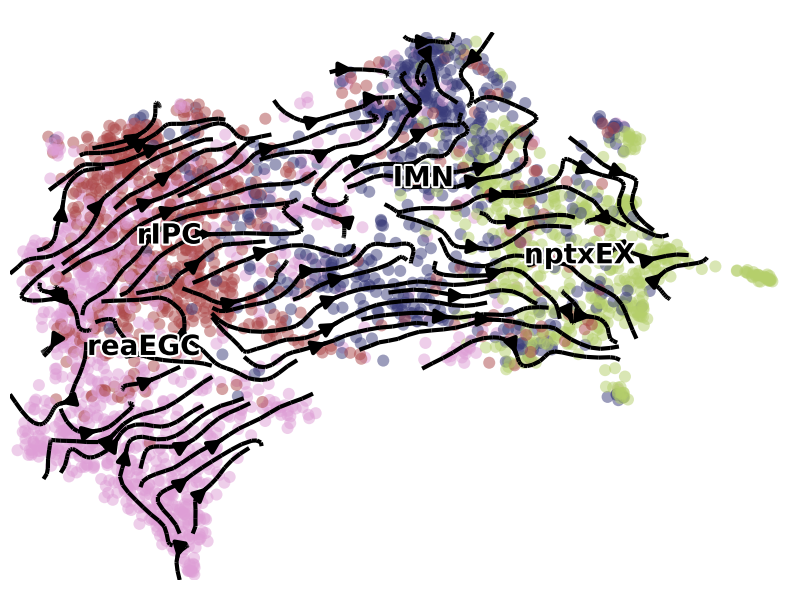

In [17]:
fig,axs=plt.subplots(ncols=1,nrows=1,figsize=(8,6))

ax = sc.pl.embedding(adata, basis ='X_umap',show=False,color='cluster',ax=axs,legend_loc='on data',frameon=False,title=' ',legend_fontsize=20,
                     legend_fontoutline =3,legend_fontweight='bold',alpha=0.5,size=300)

ax.streamplot(adata.uns['P_grid'][0], adata.uns['P_grid'][1], adata.uns['V_grid'][0], adata.uns['V_grid'][1],density=2,color='black',linewidth=3,arrowsize=2,minlength=0.2,maxlength=0.8)

plt.tight_layout()

In [ ]:

possible_markers = {
    'microglia': ['c1q', 'ctsl', 'aif1', 'cd68', 'iba1', 'tmem119', 'p2ry12', 'cx3cr1'],
    'reaEGC': ['vim', 's100', 'gfap', 'sox2', 's100a10', 'nestin', 'fabp7', 'blbp']
}


=== 尝试查找标记基因变体 ===
